In [1]:
# to generate report, run 
# pdf2txt.py report_feb_march.pdf > 0220_0322.txt

In [2]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

babytrack


In [14]:
import re
import datetime
from time import strptime
from typing import List
import math
import pandas as pd
import numpy as np
import matplotlib

In [4]:
feeding_nursing_pattern = re.compile('Feeding Nursing (.*) min .*')
feeding_expressed_pattern = re.compile('Feeding Expressed (.*) ml')
feeding_formula_pattern = re.compile('Feeding Formula (.*) ml')
diaper_wet = re.compile('Diaper change Wet')
diaper_dirty = re.compile('Diaper change ((Dirty|Mixed))')
date_pattern = re.compile(r'(\w+), (\w+) (\d{1,2}), (\d{4})')
hour_pattern = re.compile(r'(\d{1,2}):(\d{1,2}) (AM|PM)')
sleep_pattern = re.compile('Sleep Slept ((\d+) hrs )?(\d+) min')

In [5]:
def get_date(matched): 
    year = int(date_match.group(4))
    month_name = date_match.group(2)
    month = strptime(month_name[:3],'%b').tm_mon 
    day = int(date_match.group(3))
    return (year, month, day)

In [6]:
def get_datetime(current_date, hour_match): 
    hour = int(hour_match.group(1))
    minute = int(hour_match.group(2))
    ampm = hour_match.group(3)
    if ampm == 'PM':
        if hour < 12: # noon should be left alone 
            hour += 12
    else:
        if hour == 12: # midnight starts at 0 
            hour = 0
    current_time = datetime.datetime.combine(current_date, datetime.time(hour, minute)) 
    return current_time

In [7]:
def assign_bucket(time, start_time) -> int: 
    # returns a bucket index based on which bucket the time falls under
    interval_minutes = 15
    delta_minutes = (time - start_time)/datetime.timedelta(minutes=1)
    leftover = delta_minutes/interval_minutes
    return math.ceil(leftover)

In [19]:
six_pm = datetime.time(hour=18, minute=0)
arr = []

with open('0220_0322.txt') as fh: 
    current_date = None
    current_time = None
    for line in fh: 
        date_match = date_pattern.match(line)
        if date_match:
            year, month, day = get_date(date_match)
            date = datetime.date(year, month, day)
            current_date = date
        hour_match = hour_pattern.match(line)
        if hour_match and current_date: 
            current_time = get_datetime(current_date, hour_match)
            if current_time.hour < 18: 
                continue
        sleep_match = sleep_pattern.match(line)
        if sleep_match and sleep_match.group(1) and current_time.hour >= 18:
            sleep_hours = int(sleep_match.group(2))
            if sleep_hours > 8: # night time sleep 
                sleep_mins = int(sleep_match.group(3))
                next_time = current_time + datetime.timedelta(hours=sleep_hours, minutes=sleep_mins)
                start_time = datetime.datetime.combine(current_date, six_pm) 
                bucket_idx = assign_bucket(current_time, start_time)
                if len(arr) <= bucket_idx:
                    bucket_times = []
                else: 
                    bucket_times = arr.pop(bucket_idx - 1)   # get the over7/under7 times for this bucket 
                if not bucket_times: 
                    bucket_times = [0, 0]
                if next_time.hour >= 7: 
                    bucket_times[0] += 1   # index 0 keeps count of number of times she slept over 7 am 
                else: 
                    bucket_times[1] += 1   # index 1 keeps count of number of times she slept under 7 am 
                arr.insert(bucket_idx, bucket_times)
                
print(arr)

[[0, 1], [0, 1], [1, 2], [0, 2], [0, 6], [1, 3], [0, 1], [2, 4], [1, 4]]


In [10]:
a = np.array(arr)
df = pd.DataFrame(data=a, columns=['after 7', 'before 7'])
df

,after 7,before 7
0,0,1
1,0,1
2,1,2
3,0,2
4,0,6
5,1,3
6,0,1
7,2,4
8,1,4


<AxesSubplot:xlabel='Increasing time buckets', ylabel='Number of wake ups'>

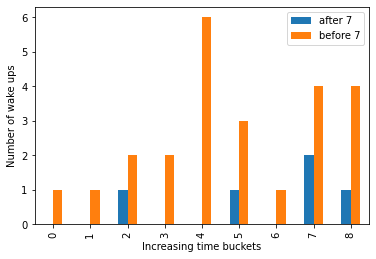

In [15]:
df.plot(kind='bar', xlabel='Increasing time buckets', ylabel='Number of wake ups')